In [1]:
from face_alignment import FaceAlignment, LandmarksType

from loreal_poc.datasets.dataset_300W import Dataset300W
from loreal_poc.visualisation.draw import draw_marks
from loreal_poc.models.face_alignment import FaceAlignmentModel
from loreal_poc.tests.performance import test_nme_mean
import numpy as np

Benchmark

In [2]:
ds = Dataset300W(dir_path="300W/sample")

L'Oreal

In [3]:
from loreal_poc.datasets.base import FacialParts, CroppedDataset

chosen_idx = 4
facial_part = FacialParts.upper_half
cropped_ds = CroppedDataset(ds, facial_part, crop_img=False)
picked_landmarks, image = cropped_ds[chosen_idx]

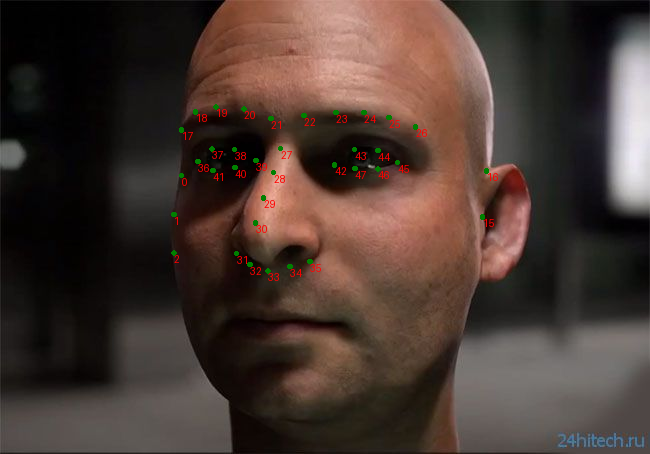

In [4]:
draw_marks(image, [picked_landmarks], ["green"], [True])

### Model 

In [5]:
model = FaceAlignmentModel(model=FaceAlignment(LandmarksType.TWO_D, device="cpu", flip_input=False))

### NME test on original dataset

In [6]:
nme_original_ds = test_nme_mean(model, ds, threshold=1)
nme_original_ds

Test "NME_mean" succeeded
               Description: Mean of normalised mean Euclidean distances across images
               Metric: 0.0623 (threshold = 1)
               
               Prediction time: 8.94 s.

## Model predictions on cropped image

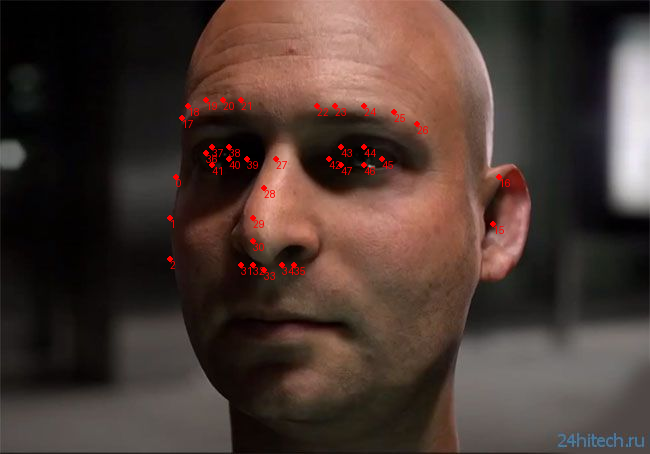

In [7]:
# from loreal_poc.transformation_functions.transformation_functions import crop_based_on_facial_part

cropped_ds = CroppedDataset(ds, facial_part, crop_img=False)


# cropped_ds = crop_based_on_facial_part(ds, facial_part, rel_margin=0.05)
# cropped_image = cropped_ds.all_images[chosen_idx]
_, cropped_image = cropped_ds[chosen_idx]
predictions = model.predict(cropped_ds, [chosen_idx], facial_part=facial_part).prediction
draw_marks(cropped_image, [predictions[0]], ["red"], [True])

## NME test on all cropped images



### rel_margin range [0.01, 0.1]

In [8]:
rel_margins = np.arange(0.0, 0.1, step=0.025)

metrics, predictions = [], []
for rel_margin in rel_margins:
    _test_result = test_nme_mean(
        model, CroppedDataset(ds, part=facial_part, margins=rel_margin), threshold=1, part=facial_part
    )
    metrics.append(_test_result.metric)
    predictions.append(_test_result.prediction_results[0].prediction)

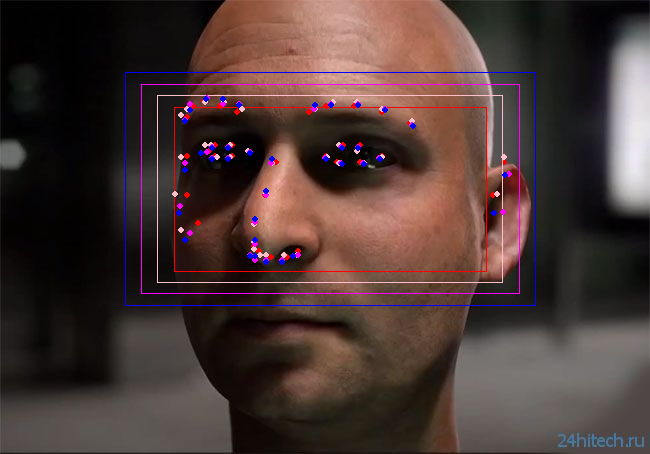

In [9]:
from loreal_poc.transformation_functions.transformation_functions import get_boundaries_from_marks
from loreal_poc.datasets.base import crop_mark

colors = ["red", "pink", "magenta", "blue"]
squares = []
for rel_margin in rel_margins:
    marks, img = ds[chosen_idx]
    h, w, _ = img.shape
    margins = np.array([w, h]) * rel_margin
    cropped_mark = crop_mark(marks, facial_part)
    left, upper, right, lower = get_boundaries_from_marks(cropped_mark, margins)

    squares.append([(left, lower), (right, upper)])

draw_marks(image, [p[chosen_idx] for p in predictions], colors, squares=squares)

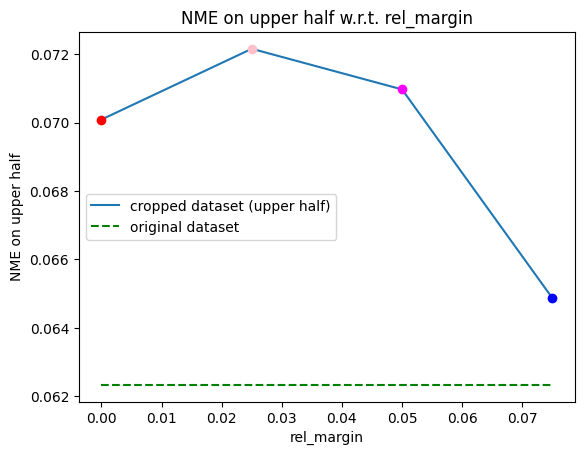

In [10]:
import matplotlib.pyplot as plt

# Plotting the Graph
plt.plot(rel_margins, metrics, label=f"cropped dataset ({facial_part.name})")
for i, p in enumerate(predictions):
    plt.plot(rel_margins[i], metrics[i], "o", c=colors[i])
plt.plot(rel_margins, [nme_original_ds.metric] * len(rel_margins), "g--", label="original dataset")
plt.title(f"NME on {facial_part.name} w.r.t. rel_margin")
plt.xlabel("rel_margin")
plt.ylabel(f"NME on {facial_part.name}")
plt.legend()
plt.show()

## NME diff (between sliced and original dataset)

In [11]:
from loreal_poc.tests.performance import test_nme_mean_diff

test_nme_mean_diff(model, ds, CroppedDataset(ds, part=facial_part, margins=0.01), threshold=1, part=facial_part)

Test "NME_mean_diff" succeeded
               Description: Difference between the NME_mean of the original and transformed images
               Metric: 0.2796 (threshold = 1)
               
               Prediction time: 10.14 s.

In [12]:
from loreal_poc.tests.performance import test_nme_std_diff

test_nme_std_diff(model, ds, CroppedDataset(ds, part=facial_part, margins=0.01), threshold=1, part=facial_part)

Test "NME_std_diff" failed
               Description: Difference between the NME_std of the original and transformed images
               Metric: 1.8747 (threshold = 1)
               
               Prediction time: 11.48 s.